In [10]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import warnings
warnings.filterwarnings("ignore")
from glob import glob as glob

# Modifications in Rich Countries

Population
- remove: Bahrain
- add: Israel

GBD
- remove: Bahrain, 
- add: Andorra, Israel

# Merge Population Files

In [9]:
def get_filepaths(directory):
    file_paths = []

    # Walk the tree.
    for root, directories, files in os.walk(directory):
        for filename in files:
            if filename.endswith('.csv'):
                filepath = os.path.join(root, filename)
                file_paths.append(filepath)  

    return file_paths

In [16]:
glob('Population/*/*.CSV')

['Population/IHME_GBD_2019_POP_1950_1959_0/IHME_GBD_2019_POP_1954_Y2020M10D15.CSV',
 'Population/IHME_GBD_2019_POP_1950_1959_0/IHME_GBD_2019_POP_1953_Y2020M10D15.CSV',
 'Population/IHME_GBD_2019_POP_1950_1959_0/IHME_GBD_2019_POP_1952_Y2020M10D15.CSV',
 'Population/IHME_GBD_2019_POP_1950_1959_0/IHME_GBD_2019_POP_1955_Y2020M10D15.CSV',
 'Population/IHME_GBD_2019_POP_1950_1959_0/IHME_GBD_2019_POP_1950_Y2020M10D15.CSV',
 'Population/IHME_GBD_2019_POP_1950_1959_0/IHME_GBD_2019_POP_1957_Y2020M10D15.CSV',
 'Population/IHME_GBD_2019_POP_1950_1959_0/IHME_GBD_2019_POP_1958_Y2020M10D15.CSV',
 'Population/IHME_GBD_2019_POP_1950_1959_0/IHME_GBD_2019_POP_1956_Y2020M10D15.CSV',
 'Population/IHME_GBD_2019_POP_1950_1959_0/IHME_GBD_2019_POP_1959_Y2020M10D15.CSV',
 'Population/IHME_GBD_2019_POP_1950_1959_0/IHME_GBD_2019_POP_1951_Y2020M10D15.CSV',
 'Population/IHME_GBD_2019_POP_1980_1989_0/IHME_GBD_2019_POP_1988_Y2020M10D15.CSV',
 'Population/IHME_GBD_2019_POP_1980_1989_0/IHME_GBD_2019_POP_1987_Y2020M10D1

In [7]:
get_filepaths('Population')

[]

In [20]:
def merge_files(file_paths, filters=None, ignore_cols=None):
    dfs = []
    for file in tq(file_paths):
        df = pd.read_csv(file)
        if filters:
            for column, values in filters.items():
                df = df[df[column].apply(lambda x: x in values)]

        dfs.append(df.drop(ignore_cols, axis=1))

    return pd.concat(dfs, ignore_index=True)

In [21]:
filters = {'age_group_name': ['10 to 14', '15 to 19', '20 to 24', '25 to 29', '30 to 34', '35 to 39', '40 to 44',
                               '45 to 49', '50 to 54', '55 to 59', '60 to 64', '65 to 69', '70 to 74', '75 to 79',
                               '80 to 84', '85 to 89', '90 to 94', '95 plus', '1 to 4', '5 to 9', '<1 year'],
           'sex_name': ['male', 'female'],
           'location_name': pd.read_csv('Processed Data/Rich Countries.csv')['Country Name'].to_list()
          }

df_pop = merge_files(glob('Population/*/*.CSV'), filters, ignore_cols=['location_id', 'sex_id', 'age_group_id', 'measure_id', 'metric_id'])

  0%|          | 0/70 [00:00<?, ?it/s]

In [7]:
df_pop['age_group_name'] = df_pop['age_group_name'].replace({'1 to 4': '1-4', '5 to 9': '5-9', '10 to 14': '10-14', '15 to 19': '15-19', '20 to 24': '20-24', '25 to 29': '25-29',
                                   '30 to 34': '30-34', '35 to 39': '35-39', '40 to 44': '40-44', '45 to 49': '45-49', '50 to 54': '50-54',
                                   '55 to 59': '55-59', '60 to 64': '60-64', '65 to 69': '65-69', '70 to 74': '70-74', '75 to 79': '75-79',
                                   '<1 year': '<1', '80 to 84': '80-84', '85 to 89': '85-89', '90 to 94': '90-94', '95 plus': '95+'})

df_pop['sex_name'] = df_pop['sex_name'].replace({'male': 'Male', 'female': 'Female'})

In [9]:
df_pop.to_csv('Processed Data/Population_1990-2019.csv', index=False)

# Base Data for Age Adjustment

In [8]:
def get_filepaths(directory):
    file_paths = []

    # Walk the tree.
    for root, directories, files in os.walk(directory):
        for filename in files:
            if filename.endswith('.csv'):
                filepath = os.path.join(root, filename)
                file_paths.append(filepath)  

    return file_paths

In [9]:
files = get_filepaths('Raw Data')

df_old = pd.read_csv(files[0])

for new_file in tq(files):
    df_new = pd.read_csv(new_file)
    df_old = pd.concat([df_old, df_new], verify_integrity=False)
    # print(df_old.shape)

  0%|          | 0/35 [00:00<?, ?it/s]

In [10]:
df_old['measure'].unique()

array(['YLLs (Years of Life Lost)', 'Deaths'], dtype=object)

In [11]:
df_deaths = df_old.copy()
df_deaths = df_deaths[df_deaths['measure'] == 'Deaths'].reset_index()

df_yll = df_old.copy()
df_yll = df_yll[df_yll['measure'] == 'YLLs (Years of Life Lost)'].reset_index()

In [12]:
# rich countries

df_rich = pd.read_csv('Processed Data/Rich Countries.csv')
rc = df_rich['Country Name'].to_list()

# population
df_pop_raw = pd.read_csv('Processed Data/Population_1990-2019.csv')
df_pop_raw['CN'] = df_pop_raw['location_name'].apply(lambda x: 'USA' if x == 'United States of America' else 'ORC') 

df_pop = df_pop_raw.groupby(['age_group_name', 'year_id', 'CN']).agg({'val':'sum'}).reset_index()
df_pop.rename(columns={'age_group_name': 'age', 'year_id': 'year', 'val': 'pop'}, inplace=True)

pop_us = df_pop[(df_pop['CN'] == 'USA') & (df_pop['year'] == 2017)]
pop_us['weight'] = pop_us['pop']/pop_us['pop'].sum()
pop_us.rename(columns={'age_group_name': 'age', 'pop': 'pop_us17'}, inplace=True)

# Standardizing

In [29]:
df_pop_raw = pd.read_csv('Processed Data/Population_1990-2019.csv')

In [30]:
set(pd.read_csv('Processed Data/Rich Countries.csv')['Country Name'].unique()) - set(df_pop_raw['location_name'].unique())

{'Czech Republic', 'United States'}

In [31]:
len(sorted(df_pop_raw['location_name'].unique()))

28

In [32]:
# df = pd.read_csv('Rich Countries.csv')

In [33]:
# for country in df['Country Name'].to_list():
#     print(country, country in df_pop['location_name'].unique())

In [34]:
df_pop_raw.head()

,location_name,sex_name,age_group_name,year_id,measure_name,metric_name,val,upper,lower
0,Czechia,Male,1-4,1954,Population,Number,354362.456414,386528.967206,320298.071876
1,Czechia,Male,5-9,1954,Population,Number,438052.488428,477815.786829,395943.094095
2,Czechia,Male,10-14,1954,Population,Number,352144.668137,384109.863838,318293.476592
3,Czechia,Male,15-19,1954,Population,Number,281886.925769,307474.621858,254789.516148
4,Czechia,Male,20-24,1954,Population,Number,322768.461019,352067.092961,291741.164605


In [35]:
# df_pop[(df_pop['location_name']=='United States of America') & (df_pop['age_group_name']=='75-79') & (df_pop['year_id']==1990)]['val'].sum()

In [46]:
# gbd_raw = pd.read_csv('GBD - Rich Countries.csv')
gbd_raw = df_deaths[~df_deaths['sex'].isin(['Male', 'Female'])].copy()
gbd_raw.rename(columns={'location': 'Country Name'}, inplace=True)
df_pop_raw = pd.read_csv('Processed Data/Population_1990-2019.csv')

In [47]:
len(sorted(gbd_raw['Country Name'].unique()))

204

In [48]:
gbd_raw['CN'] = gbd_raw['Country Name'].apply(lambda x: 'USA' if x == 'United States of America' else 'ORC') 
df_pop_raw['CN'] = df_pop_raw['location_name'].apply(lambda x: 'USA' if x == 'United States of America' else 'ORC') 

In [49]:
df_pop = df_pop_raw.groupby(['sex_name', 'age_group_name', 'year_id', 'CN']).agg({'val': 'sum'}).reset_index()

In [50]:
df_pop.head()

,sex_name,age_group_name,year_id,CN,val
0,Female,1-4,1950,ORC,3.307690e+07
1,Female,1-4,1950,USA,1.300228e+07
2,Female,1-4,1951,ORC,1.715147e+07
3,Female,1-4,1951,USA,6.915022e+06
4,Female,1-4,1952,ORC,1.687154e+07


In [51]:
gbd = gbd_raw.groupby(['sex', 'age', 'cause', 'year', 'CN']).agg({'val': 'sum'}).reset_index()
gbd['Deaths Std'] = np.nan 
gbd['Death Rate'] = np.nan

In [52]:
gbd[(gbd['age'] == '85-89') & (gbd['year'] == 2017) & (gbd['cause'] == 'Neoplasms')]

,sex,age,cause,year,CN,val,Deaths Std,Death Rate
24054,Both,85-89,Neoplasms,2017,ORC,612644.703551,NaN,NaN
24055,Both,85-89,Neoplasms,2017,USA,71917.310046,NaN,NaN


In [163]:
df_pop_raw[(df_pop_raw['age_group_name'] == '85-89') & (df_pop_raw['year_id'] == 2017) & (df_pop_raw['CN'] == 'USA')]

,location_name,sex_name,age_group_name,year_id,measure_name,metric_name,val,upper,lower,CN
42270,United States of America,Male,85-89,2017,Population,Number,1.454614e+06,1.630836e+06,1.294799e+06,USA
42291,United States of America,Female,85-89,2017,Population,Number,2.371013e+06,2.658254e+06,2.110515e+06,USA


In [166]:
((34788 + 37128)*100000)/df_pop_raw[(df_pop_raw['age_group_name'] == '85-89') & (df_pop_raw['year_id'] == 2017) & (df_pop_raw['CN'] == 'USA')]['val'].sum()

1879.8488998911619

In [145]:
df_pop_raw

,location_name,sex_name,age_group_name,year_id,measure_name,metric_name,val,upper,lower
0,Czechia,Male,1-4,1954,Population,Number,354362.456414,386528.967206,320298.071876
1,Czechia,Male,5-9,1954,Population,Number,438052.488428,477815.786829,395943.094095
2,Czechia,Male,10-14,1954,Population,Number,352144.668137,384109.863838,318293.476592
3,Czechia,Male,15-19,1954,Population,Number,281886.925769,307474.621858,254789.516148
4,Czechia,Male,20-24,1954,Population,Number,322768.461019,352067.092961,291741.164605
...,...,...,...,...,...,...,...,...,...
83491,Bermuda,Female,<1,1994,Population,Number,414.769982,448.460912,378.869203
83492,Bermuda,Female,80-84,1994,Population,Number,433.221670,468.411393,395.723789
83493,Bermuda,Female,85-89,1994,Population,Number,226.427765,244.820036,206.829112
83494,Bermuda,Female,90-94,1994,Population,Number,81.362827,87.971765,74.320396


In [139]:
gbd['cause'].unique()

array(['Cardiovascular diseases', 'Chronic respiratory diseases',
       'Cirrhosis and other chronic liver diseases',
       'Diabetes and kidney diseases',
       'HIV/AIDS and sexually transmitted infections',
       'Interpersonal violence', 'Neoplasms', 'Other',
       'Substance use disorders', 'Transport injuries', 'Self-harm'],
      dtype=object)

In [15]:
gbd

,sex,age,cause,year,CN,val,Deaths Std,Death Rate
0,Female,1-4,Cardiovascular diseases,1990,ORC,176.132651,NaN,NaN
1,Female,1-4,Cardiovascular diseases,1990,USA,120.842353,NaN,NaN
2,Female,1-4,Cardiovascular diseases,1991,ORC,170.956238,NaN,NaN
3,Female,1-4,Cardiovascular diseases,1991,USA,123.519036,NaN,NaN
4,Female,1-4,Cardiovascular diseases,1992,ORC,166.242414,NaN,NaN
...,...,...,...,...,...,...,...,...
27235,Male,<1,Transport injuries,2017,USA,66.337767,NaN,NaN
27236,Male,<1,Transport injuries,2018,ORC,29.573058,NaN,NaN
27237,Male,<1,Transport injuries,2018,USA,63.846168,NaN,NaN
27238,Male,<1,Transport injuries,2019,ORC,28.429180,NaN,NaN


In [16]:
gbd.sample(10)

,sex,age,cause,year,CN,val,Deaths Std,Death Rate
10431,Female,75-79,Transport injuries,2015,USA,641.662702,NaN,NaN
26848,Male,<1,Diabetes and kidney diseases,2004,ORC,43.941532,NaN,NaN
26037,Male,90-94,Transport injuries,2018,USA,299.666104,NaN,NaN
24549,Male,80-84,Self-harm,1994,USA,943.613433,NaN,NaN
10778,Female,80-84,Interpersonal violence,2009,ORC,59.875861,NaN,NaN
15432,Male,15-19,Substance use disorders,1996,ORC,288.833892,NaN,NaN
13473,Female,<1,Other,2006,USA,11913.946087,NaN,NaN
16578,Male,25-29,Neoplasms,1999,ORC,1873.683070,NaN,NaN
11918,Female,90-94,Cirrhosis and other chronic liver diseases,2009,ORC,2609.620899,NaN,NaN
144,Female,1-4,Cirrhosis and other chronic liver diseases,2002,ORC,15.670974,NaN,NaN


In [17]:
df_pop.head(2)

,sex_name,age_group_name,year_id,CN,val
0,Female,1-4,1950,ORC,3.307690e+07
1,Female,1-4,1950,USA,1.300228e+07


In [18]:
gbd['age'].unique()

array(['1-4', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39',
       '40-44', '45-49', '5-9', '50-54', '55-59', '60-64', '65-69',
       '70-74', '75-79', '80-84', '85-89', '90-94', '95+', '<1'],
      dtype=object)

In [11]:
# # print(gbd.shape)
# pop_us_2017 = df_pop[(df_pop['year_id'] == 2017) & (df_pop['CN'] == 'USA')]

# for age in sorted(gbd['age'].unique()):
#     # limit = 0
#     df_pop_curr = df_pop[(df_pop['age_group_name'] == age) & (df_pop['CN'] == 'USA')]
#     gbd_curr = gbd[(gbd['age'] == age) & (gbd['CN']=='USA')]
    
#     with tq(total = gbd_curr.shape[0]) as pbar1:
#         pbar1.set_description(str(age))
        
#         for index, row in gbd_curr.iterrows():
            
#             # print(row)
#             sex = row['sex']
#             year = row['year']
            
#             pop_age_group = df_pop_curr[(df_pop_curr['sex_name'] == sex) & (df_pop_curr['year_id'] == year)]
#             pop_us_age = pop_us_2017[(pop_us_2017['sex_name'] == sex) & (pop_us_2017['age_group_name'] == age)]
#             # print()
#             # print(row['val'])
#             # print(pop_us_age['val'].item())
#             # print(pop_age_group['val'].item())
#             # print(pop_us_age['val'])
#             # print(pop_us_2017[pop_us_2017['sex_name'] == sex]['val'].sum())
#             deaths_std = (row['val'] * pop_us_age['val'].item())/pop_age_group['val'].item()
#             gbd.loc[index, 'Deaths Std'] = deaths_std
#             gbd.loc[index, 'Death Rate'] = (row['val']/pop_age_group['val'].item()) * pow(10,5)
#             pbar1.update(1)

#         # print(gbd.iloc[index])

#             # limit += 1
#             # if limit >= 5:
#             #     break

### USA, ORC sex=both

In [82]:
gbd = gbd_raw.groupby(['age', 'cause', 'year', 'CN']).agg({'val': 'sum'}).reset_index()
# gbd['Deaths Std'] = np.nan 
# gbd['Death Rate'] = np.nan
gbd.head()

,age,cause,year,CN,val
0,1-4 years,Cardiovascular diseases,1990,ORC,29781.616000
1,1-4 years,Cardiovascular diseases,1990,USA,247.321974
2,1-4 years,Cardiovascular diseases,1991,ORC,28782.936422
3,1-4 years,Cardiovascular diseases,1991,USA,254.537774
4,1-4 years,Cardiovascular diseases,1992,ORC,27884.856369


In [13]:
# adding CN, modifying age

causes_to_keep = ['HIV/AIDS and sexually transmitted infections',
        'Interpersonal violence', 'Neoplasms',
       'Self-harm', 'Chronic respiratory diseases',
       'Cirrhosis and other chronic liver diseases', 'Transport injuries',
       'Substance use disorders', 'Diabetes and kidney diseases',
       'Cardiovascular diseases']

deaths_raw = df_deaths[~df_deaths['sex'].isin(['Male', 'Female'])].copy()
print(deaths_raw['sex'].unique())
deaths_raw.rename(columns = {'location':'Country Name'}, inplace=True)
df_deaths_rich = deaths_raw.query("`Country Name` in @rc")
df_deaths_rich['Country Name'].unique()

df_deaths_rich['CN'] = df_deaths_rich['Country Name'].apply(lambda x: 'USA' if x == 'United States of America' else 'ORC')
print(df_deaths_rich['CN'].unique())

df_deaths_rich['age'] = df_deaths_rich['age'].apply(lambda x: x.split(' ')[0])
print(df_deaths_rich.age.unique())

# modifying causes
df_deaths_rich['cause'] = df_deaths_rich['cause'].apply(lambda x: 'Other' if x not in causes_to_keep else x)
print(df_deaths_rich.cause.unique())

['Both']
['ORC' 'USA']
['1-4' '5-9' '10-14' '15-19' '20-24' '25-29' '30-34' '35-39' '40-44'
 '45-49' '50-54' '55-59' '60-64' '65-69' '70-74' '75-79' '<1' '80-84'
 '85-89' '90-94' '95+']
['Other' 'Substance use disorders' 'Diabetes and kidney diseases'
 'Cirrhosis and other chronic liver diseases' 'Transport injuries'
 'Neoplasms' 'Cardiovascular diseases'
 'HIV/AIDS and sexually transmitted infections'
 'Chronic respiratory diseases' 'Self-harm' 'Interpersonal violence']


In [105]:
df_deaths_rich

,index,measure,Country Name,sex,age,cause,metric,year,val,upper,lower,CN
2510,2510,Deaths,Netherlands,Both,1-4,Other,Number,2014,15.512021,20.893299,10.921599,ORC
2513,2513,Deaths,Netherlands,Both,5-9,Other,Number,2014,7.259305,8.812011,5.943033,ORC
2516,2516,Deaths,Netherlands,Both,10-14,Other,Number,2014,5.849076,7.070761,4.742858,ORC
2519,2519,Deaths,Netherlands,Both,15-19,Other,Number,2014,9.689863,11.544863,8.113186,ORC
2522,2522,Deaths,Netherlands,Both,20-24,Other,Number,2014,13.516623,15.900190,11.453167,ORC
...,...,...,...,...,...,...,...,...,...,...,...,...
8683462,499182,Deaths,United Kingdom,Both,80-84,Neoplasms,Number,2002,25329.410294,26434.216352,23165.481121,ORC
8683465,499185,Deaths,United Kingdom,Both,85-89,Neoplasms,Number,2002,17499.620020,18617.168456,15257.255949,ORC
8683468,499188,Deaths,United Kingdom,Both,90-94,Neoplasms,Number,2002,8538.434125,9221.180111,7141.418526,ORC
8683471,499191,Deaths,United Kingdom,Both,95+,Neoplasms,Number,2002,2808.581999,3066.963322,2282.624567,ORC


In [110]:
df_deaths_rich

,index,measure,Country Name,sex,age,cause,metric,year,val,upper,lower,CN
2510,2510,Deaths,Netherlands,Both,1-4,Other,Number,2014,15.512021,20.893299,10.921599,ORC
2513,2513,Deaths,Netherlands,Both,5-9,Other,Number,2014,7.259305,8.812011,5.943033,ORC
2516,2516,Deaths,Netherlands,Both,10-14,Other,Number,2014,5.849076,7.070761,4.742858,ORC
2519,2519,Deaths,Netherlands,Both,15-19,Other,Number,2014,9.689863,11.544863,8.113186,ORC
2522,2522,Deaths,Netherlands,Both,20-24,Other,Number,2014,13.516623,15.900190,11.453167,ORC
...,...,...,...,...,...,...,...,...,...,...,...,...
8683462,499182,Deaths,United Kingdom,Both,80-84,Neoplasms,Number,2002,25329.410294,26434.216352,23165.481121,ORC
8683465,499185,Deaths,United Kingdom,Both,85-89,Neoplasms,Number,2002,17499.620020,18617.168456,15257.255949,ORC
8683468,499188,Deaths,United Kingdom,Both,90-94,Neoplasms,Number,2002,8538.434125,9221.180111,7141.418526,ORC
8683471,499191,Deaths,United Kingdom,Both,95+,Neoplasms,Number,2002,2808.581999,3066.963322,2282.624567,ORC


In [14]:
deaths = df_deaths_rich.groupby(['age', 'cause', 'year', 'CN']).agg({'val': 'sum'}).reset_index().rename(columns={'val': 'deaths'})

In [123]:
deaths

,age,cause,year,CN,deaths
0,1-4,Cardiovascular diseases,1990,ORC,359.971925
1,1-4,Cardiovascular diseases,1990,USA,247.321974
2,1-4,Cardiovascular diseases,1991,ORC,349.097480
3,1-4,Cardiovascular diseases,1991,USA,254.537774
4,1-4,Cardiovascular diseases,1992,ORC,339.999176
...,...,...,...,...,...
13615,<1,Transport injuries,2017,USA,120.905748
13616,<1,Transport injuries,2018,ORC,51.987583
13617,<1,Transport injuries,2018,USA,116.207556
13618,<1,Transport injuries,2019,ORC,49.928416


In [124]:
df_pop2 = df_pop_raw.groupby(['age_group_name', 'year_id', 'CN']).agg({'val': 'sum'}).reset_index()
df_pop2.head()

,age_group_name,year_id,CN,val
0,1-4,1950,ORC,6.769945e+07
1,1-4,1950,USA,2.644659e+07
2,1-4,1951,ORC,3.509529e+07
3,1-4,1951,USA,1.403095e+07
4,1-4,1952,ORC,3.450884e+07


In [68]:
# df_pop.head()

,age,year,CN,pop
0,1-4,1950,ORC,6.769945e+07
1,1-4,1950,USA,2.644659e+07
2,1-4,1951,ORC,3.509529e+07
3,1-4,1951,USA,1.403095e+07
4,1-4,1952,ORC,3.450884e+07


In [125]:
gbd

,age,cause,year,CN,val
0,1-4 years,Cardiovascular diseases,1990,ORC,29781.616000
1,1-4 years,Cardiovascular diseases,1990,USA,247.321974
2,1-4 years,Cardiovascular diseases,1991,ORC,28782.936422
3,1-4 years,Cardiovascular diseases,1991,USA,254.537774
4,1-4 years,Cardiovascular diseases,1992,ORC,27884.856369
...,...,...,...,...,...
28555,<1 year,Unintentional injuries,2017,USA,1293.434717
28556,<1 year,Unintentional injuries,2018,ORC,56175.698262
28557,<1 year,Unintentional injuries,2018,USA,1226.876550
28558,<1 year,Unintentional injuries,2019,ORC,53868.232512


In [15]:
dff_mid = deaths.merge(df_pop, left_on = ['age', 'year', 'CN'], right_on=['age', 'year', 'CN'])

dff = dff_mid.merge(pop_us[['age', 'pop_us17', 'weight']])

dff['Deaths Std'] = (dff['deaths'] * dff['pop_us17'])/dff['pop']
dff['Death Rate'] = (dff['deaths']/dff['pop']) * pow(10,5)
dff['aa_dr'] = ((dff['deaths'] * pow(10,5)) / dff['pop']) * dff['weight']

In [17]:
# dff = pd.read_csv('Processed Data/GHD - Rich Countries.csv')

In [18]:
dff.head()

,age,cause,year,CN,deaths,pop,pop_us17,weight,Deaths Std,Death Rate,aa_dr
0,1-4,Cardiovascular diseases,1990,ORC,359.971925,2.671558e+07,1.551091e+07,0.047792,208.997636,1.347423,0.064396
1,1-4,Chronic respiratory diseases,1990,ORC,181.964379,2.671558e+07,1.551091e+07,0.047792,105.647475,0.681117,0.032552
2,1-4,Cirrhosis and other chronic liver diseases,1990,ORC,71.666268,2.671558e+07,1.551091e+07,0.047792,41.609024,0.268256,0.012820
3,1-4,Diabetes and kidney diseases,1990,ORC,72.885164,2.671558e+07,1.551091e+07,0.047792,42.316708,0.272819,0.013038
4,1-4,HIV/AIDS and sexually transmitted infections,1990,ORC,61.043242,2.671558e+07,1.551091e+07,0.047792,35.441356,0.228493,0.010920


In [19]:
df = dff[(dff['CN']=='USA') & (dff['year']==1990)].groupby(['cause', 'year', 'CN']).agg({'aa_dr':'sum'})
df['percent'] = df['aa_dr']/df['aa_dr'].sum()*100
# df['percent2'] = df['aa_yll2']/df['aa_yll2'].sum()*100
for col in ['percent']:
    df[col] = df[col].apply(lambda x: np.round(x, 2))
df

,,,aa_dr,percent
cause,year,CN,,
Cardiovascular diseases,1990,USA,467.583136,41.48
Chronic respiratory diseases,1990,USA,53.669976,4.76
Cirrhosis and other chronic liver diseases,1990,USA,18.607981,1.65
Diabetes and kidney diseases,1990,USA,41.406334,3.67
HIV/AIDS and sexually transmitted infections,1990,USA,10.370210,0.92
Interpersonal violence,1990,USA,9.268305,0.82
Neoplasms,1990,USA,274.329469,24.34
Other,1990,USA,211.946992,18.80
Self-harm,1990,USA,14.012587,1.24


In [20]:
df = dff[(dff['CN']=='ORC') & (dff['year']==2017)].groupby(['cause', 'year', 'CN']).agg({'aa_dr':'sum'})
df['percent'] = df['aa_dr']/df['aa_dr'].sum()*100
# df['percent2'] = df['aa_yll2']/df['aa_yll2'].sum()*100
for col in ['percent']:
    df[col] = df[col].apply(lambda x: np.round(x, 2))
df

,,,aa_dr,percent
cause,year,CN,,
Cardiovascular diseases,2017,ORC,209.397512,29.21
Chronic respiratory diseases,2017,ORC,35.619522,4.97
Cirrhosis and other chronic liver diseases,2017,ORC,14.292777,1.99
Diabetes and kidney diseases,2017,ORC,31.288957,4.36
HIV/AIDS and sexually transmitted infections,2017,ORC,0.651253,0.09
Interpersonal violence,2017,ORC,0.795447,0.11
Neoplasms,2017,ORC,220.012711,30.69
Other,2017,ORC,181.947014,25.38
Self-harm,2017,ORC,12.228583,1.71


In [55]:
# USA

# print(gbd.shape)
pop_us_2017 = df_pop[(df_pop['year_id'] == 2017) & (df_pop['CN'] == 'USA')]

for age in sorted(gbd['age'].unique()):
    # limit = 0
    df_pop_curr = df_pop[(df_pop['age_group_name'] == age) & (df_pop['CN'] == 'USA')]
    gbd_curr = gbd[(gbd['age'] == age) & (gbd['CN']=='USA')]
    
    with tq(total = gbd_curr.shape[0]) as pbar1:
        pbar1.set_description(str(age))
        
        for index, row in gbd_curr.iterrows():
            
            # print(row)
            # sex = row['sex']
            year = row['year']
            
            pop_age_group = df_pop_curr[(df_pop_curr['year_id'] == year)]
            pop_us_age = pop_us_2017[(pop_us_2017['age_group_name'] == age)]
            # print()
            # print(row['val'])
            # print(pop_us_age['val'].item())
            # print(pop_age_group['val'].item())
            # print(pop_us_age['val'])
            # print(pop_us_2017[pop_us_2017['sex_name'] == sex]['val'].sum())
            deaths_std = (row['val'] * pop_us_age['val'].item())/pop_age_group['val'].item()
            gbd.loc[index, 'Deaths Std'] = deaths_std
            gbd.loc[index, 'Death Rate'] = (row['val']/pop_age_group['val'].item()) * pow(10,5)
            pbar1.update(1)

        # print(gbd.iloc[index])

            # limit += 1
            # if limit >= 5:
            #     break

  0%|          | 0/630 [00:00<?, ?it/s]

ValueError: can only convert an array of size 1 to a Python scalar

In [56]:
# ORC

# For ORC for a particular age group-year-cause combination: sum of deaths in that group over all ORC) * (2017 US pop in that group) / (sum of pops in that group over all ORC)
# print(gbd.shape)
pop_us_2017 = df_pop[(df_pop['year_id'] == 2017) & (df_pop['CN'] == 'USA')]

for age in sorted(gbd['age'].unique()):
    # limit = 0
    df_pop_curr = df_pop[(df_pop['age_group_name'] == age) & (df_pop['CN'] == 'ORC')]
    gbd_curr = gbd[(gbd['age'] == age) & (gbd['CN']=='ORC')]
    
    with tq(total = gbd_curr.shape[0]) as pbar1:
        pbar1.set_description(str(age))
        
        for index, row in gbd_curr.iterrows():
            
            # print(row)
            # sex = row['sex']
            year = row['year']
            
            pop_age_group = df_pop_curr[ (df_pop_curr['year_id'] == year)]
            pop_us_age = pop_us_2017[ (pop_us_2017['age_group_name'] == age)]
            # print()
            # print(row['val'])
            # print(pop_us_age['val'].item())
            # print(pop_age_group['val'].item())
            # print(pop_us_age['val'])
            # print(pop_us_2017[pop_us_2017['sex_name'] == sex]['val'].sum())
            deaths_std = (row['val'] * pop_us_age['val'].item())/pop_age_group['val'].item()
            gbd.loc[index, 'Deaths Std'] = deaths_std
            gbd.loc[index, 'Death Rate'] = (row['val']/pop_age_group['val'].item()) * pow(10,5)
            pbar1.update(1)

        # print(gbd.iloc[index])

            # limit += 1
            # if limit >= 5:
            #     break

  0%|          | 0/630 [00:00<?, ?it/s]

ValueError: can only convert an array of size 1 to a Python scalar

In [21]:
# gbd[gbd['Country Name']=='United States of America'].to_csv('GBD_USA_DeathsStandardized_DeathRates.csv', index=False)
dff.to_csv('Processed Data/GHD - Rich Countries.csv', index=False)

### USA

In [21]:
# print(gbd.shape)
pop_us_2017 = df_pop[(df_pop['year_id'] == 2017) & (df_pop['CN'] == 'USA')]

for age in sorted(gbd['age'].unique()):
    # limit = 0
    df_pop_curr = df_pop[(df_pop['age_group_name'] == age) & (df_pop['CN'] == 'USA')]
    gbd_curr = gbd[(gbd['age'] == age) & (gbd['CN']=='USA')]
    
    with tq(total = gbd_curr.shape[0]) as pbar1:
        pbar1.set_description(str(age))
        
        for index, row in gbd_curr.iterrows():
            
            # print(row)
            sex = row['sex']
            year = row['year']
            
            pop_age_group = df_pop_curr[(df_pop_curr['sex_name'] == sex) & (df_pop_curr['year_id'] == year)]
            pop_us_age = pop_us_2017[(pop_us_2017['sex_name'] == sex) & (pop_us_2017['age_group_name'] == age)]
            # print()
            # print(row['val'])
            # print(pop_us_age['val'].item())
            # print(pop_age_group['val'].item())
            # print(pop_us_age['val'])
            # print(pop_us_2017[pop_us_2017['sex_name'] == sex]['val'].sum())
            deaths_std = (row['val'] * pop_us_age['val'].item())/pop_age_group['val'].item()
            gbd.loc[index, 'Deaths Std'] = deaths_std
            gbd.loc[index, 'Death Rate'] = (row['val']/pop_age_group['val'].item()) * pow(10,5)
            pbar1.update(1)

        # print(gbd.iloc[index])

            # limit += 1
            # if limit >= 5:
            #     break

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

### ORC

In [23]:
# For ORC for a particular age group-year-cause combination: sum of deaths in that group over all ORC) * (2017 US pop in that group) / (sum of pops in that group over all ORC)
# print(gbd.shape)
pop_us_2017 = df_pop[(df_pop['year_id'] == 2017) & (df_pop['CN'] == 'USA')]

for age in sorted(gbd['age'].unique()):
    # limit = 0
    df_pop_curr = df_pop[(df_pop['age_group_name'] == age) & (df_pop['CN'] == 'ORC')]
    gbd_curr = gbd[(gbd['age'] == age) & (gbd['CN']=='ORC')]
    
    with tq(total = gbd_curr.shape[0]) as pbar1:
        pbar1.set_description(str(age))
        
        for index, row in gbd_curr.iterrows():
            
            # print(row)
            sex = row['sex']
            year = row['year']
            
            pop_age_group = df_pop_curr[(df_pop_curr['sex_name'] == sex) & (df_pop_curr['year_id'] == year)]
            pop_us_age = pop_us_2017[(pop_us_2017['sex_name'] == sex) & (pop_us_2017['age_group_name'] == age)]
            # print()
            # print(row['val'])
            # print(pop_us_age['val'].item())
            # print(pop_age_group['val'].item())
            # print(pop_us_age['val'])
            # print(pop_us_2017[pop_us_2017['sex_name'] == sex]['val'].sum())
            deaths_std = (row['val'] * pop_us_age['val'].item())/pop_age_group['val'].item()
            gbd.loc[index, 'Deaths Std'] = deaths_std
            gbd.loc[index, 'Death Rate'] = (row['val']/pop_age_group['val'].item()) * pow(10,5)
            pbar1.update(1)

        # print(gbd.iloc[index])

            # limit += 1
            # if limit >= 5:
            #     break

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

In [135]:
# gbd[gbd['Country Name']=='United States of America'].to_csv('GBD_USA_DeathsStandardized_DeathRates.csv', index=False)
dff.to_csv('Processed Data/GHD - Rich Countries.csv', index=False)

In [143]:
gbd[(gbd['year'] == 2017) & (gbd['cause'] == 'Neaplasms') & (gbd['age'] == '85-89')]

,sex,age,cause,year,CN,val,Deaths Std,Death Rate


3,621,901

# Age Adjusted Death Rate

In [ ]:
df_dr

# Age Adjusted YLL

In [19]:
df_yll.head()

,index,measure,location,sex,age,cause,metric,year,val,upper,lower
0,0,YLLs (Years of Life Lost),Solomon Islands,Both,95+ years,Respiratory infections and tuberculosis,Number,1996,1.676031,2.211292,0.966315
1,1,YLLs (Years of Life Lost),Solomon Islands,Male,1-4 years,Enteric infections,Number,1996,1589.332700,3028.943402,673.332957
2,2,YLLs (Years of Life Lost),Solomon Islands,Female,1-4 years,Enteric infections,Number,1996,1222.802356,2363.956126,483.634004
3,3,YLLs (Years of Life Lost),Solomon Islands,Both,1-4 years,Enteric infections,Number,1996,2812.135055,4813.976923,1461.866987
4,4,YLLs (Years of Life Lost),Solomon Islands,Male,5-9 years,Enteric infections,Number,1996,274.313413,468.126134,139.645571


In [22]:
# adding CN, modifying age

causes_to_keep = ['HIV/AIDS and sexually transmitted infections',
        'Interpersonal violence', 'Neoplasms',
       'Self-harm', 'Chronic respiratory diseases',
       'Cirrhosis and other chronic liver diseases', 'Transport injuries',
       'Substance use disorders', 'Diabetes and kidney diseases',
       'Cardiovascular diseases']

df_yll.rename(columns = {'location':'Country Name'}, inplace=True)
df_yll_rich = df_yll.query("`Country Name` in @rc")
df_yll_rich['Country Name'].unique()

df_yll_rich['CN'] = df_yll_rich['Country Name'].apply(lambda x: 'USA' if x == 'United States of America' else 'ORC')
print(df_yll_rich['CN'].unique())

df_yll_rich['age'] = df_yll_rich['age'].apply(lambda x: x.split(' ')[0])
print(df_yll_rich.age.unique())

# modifying causes
df_yll_rich['cause'] = df_yll_rich['cause'].apply(lambda x: 'Other' if x not in causes_to_keep else x)
print(df_yll_rich.cause.unique())

['ORC' 'USA']
['1-4' '5-9' '10-14' '15-19' '20-24' '25-29' '30-34' '35-39' '40-44'
 '45-49' '50-54' '55-59' '60-64' '65-69' '70-74' '75-79' '<1' '80-84'
 '85-89' '90-94' '95+']
['Other' 'Self-harm' 'HIV/AIDS and sexually transmitted infections'
 'Chronic respiratory diseases' 'Neoplasms' 'Interpersonal violence'
 'Substance use disorders' 'Diabetes and kidney diseases'
 'Cirrhosis and other chronic liver diseases' 'Transport injuries'
 'Cardiovascular diseases']


In [23]:
df_yll_rich.sample(5)

,index,measure,Country Name,sex,age,cause,metric,year,val,upper,lower,CN
4561430,61430,YLLs (Years of Life Lost),New Zealand,Female,1-4,HIV/AIDS and sexually transmitted infections,Number,1992,1.309781,1.843001,0.908321,ORC
321553,321553,YLLs (Years of Life Lost),Iceland,Male,90-94,Other,Number,1993,36.569266,45.486588,27.895152,ORC
6297900,297900,YLLs (Years of Life Lost),Cyprus,Male,<1,Other,Number,2010,14.928221,22.274523,9.284028,ORC
372315,372315,YLLs (Years of Life Lost),United States of America,Male,65-69,Interpersonal violence,Number,2007,4719.987696,4903.839218,4550.537163,USA
5563111,63111,YLLs (Years of Life Lost),Australia,Female,<1,Diabetes and kidney diseases,Number,2014,93.046496,126.235499,65.972353,ORC


In [24]:
df_yll = df_yll_rich[~df_yll_rich['sex'].isin(['Male', 'Female'])]
yll = df_yll[['CN', 'age', 'cause', 'year', 'val']].rename(columns={'val': 'yll'})

In [25]:
yll.sample(5)

,CN,age,cause,year,yll
1221128,ORC,80-84,Other,1998,47.710474
6055078,ORC,95+,Other,2009,5.461725
6299570,ORC,55-59,Other,2000,5205.914944
1876609,ORC,65-69,Other,2003,1375.884095
2822342,ORC,85-89,Cirrhosis and other chronic liver diseases,2015,172.373221


In [28]:
# age-adjusted calculation
dff_mid = yll.merge(df_pop, left_on=['age', 'year', 'CN'], right_on=['age', 'year', 'CN'])

dff = dff_mid.merge(pop_us[['age', 'pop_us17', 'weight']])

dff['aa_yll'] = ((dff['yll'] * pow(10,5)) / dff['pop']) * dff['weight']
dff['aa_yll2'] = (dff['yll'] / (dff['pop'] * pow(10,5))) * dff['pop_us17']
dff

,CN,age,cause,year,yll,pop,pop_us17,weight,aa_yll,aa_yll2
0,ORC,1-4,Other,1997,3932.699052,2.538195e+07,1.551091e+07,0.047792,0.740489,0.024033
1,ORC,1-4,HIV/AIDS and sexually transmitted infections,1997,3.750686,2.538195e+07,1.551091e+07,0.047792,0.000706,0.000023
2,ORC,1-4,Other,1997,10.579304,2.538195e+07,1.551091e+07,0.047792,0.001992,0.000065
3,ORC,1-4,Other,1997,2.756308,2.538195e+07,1.551091e+07,0.047792,0.000519,0.000017
4,ORC,1-4,Other,1997,7.986726,2.538195e+07,1.551091e+07,0.047792,0.001504,0.000049
...,...,...,...,...,...,...,...,...,...,...
421642,USA,95+,Other,1990,28491.884815,2.734536e+05,7.486363e+05,0.002307,24.033876,0.780025
421643,USA,95+,Other,1990,213.871269,2.734536e+05,7.486363e+05,0.002307,0.180408,0.005855
421644,USA,95+,Other,1990,309.759945,2.734536e+05,7.486363e+05,0.002307,0.261293,0.008480
421645,USA,95+,Substance use disorders,1990,52.160602,2.734536e+05,7.486363e+05,0.002307,0.043999,0.001428


#### US 1990
> age adjusted YLL = (YLL / POP) * (US 2017 Population / Total US 2017 Population)

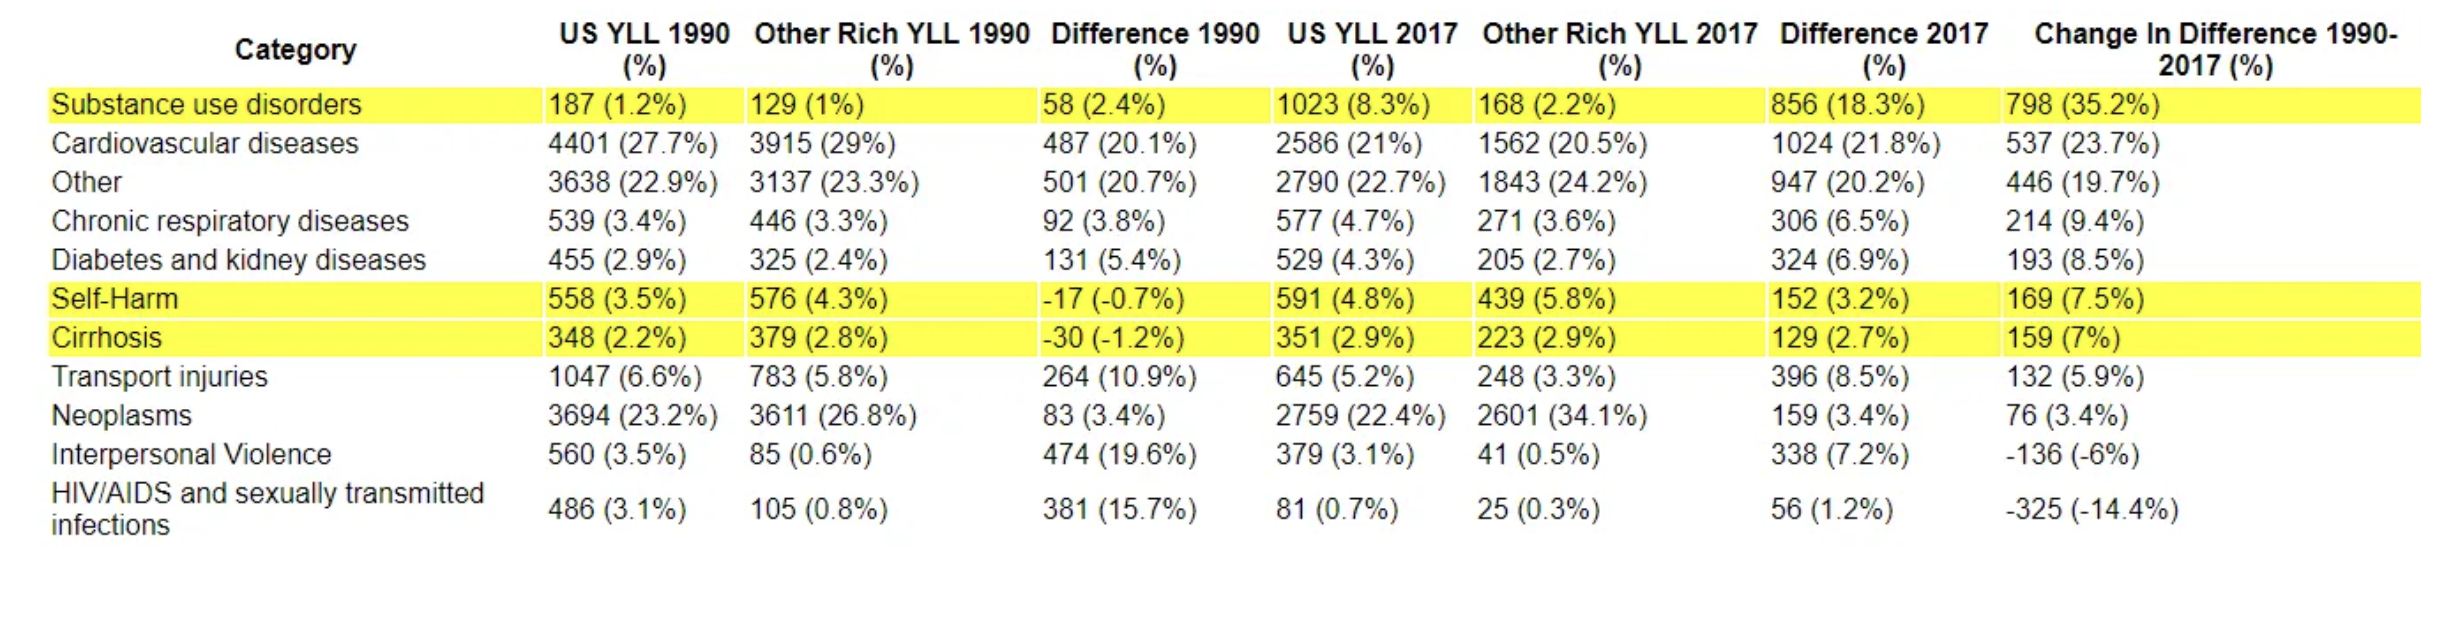

In [57]:
df = dff[(dff['CN']=='USA') & (dff['year']==2017)].groupby(['cause', 'year', 'CN']).agg({'aa_yll':'sum', 'aa_yll2': 'sum'})
df['percent'] = df['aa_yll']/df['aa_yll'].sum()*100
df['percent2'] = df['aa_yll2']/df['aa_yll2'].sum()*100
for col in ['percent', 'percent2']:
    df[col] = df[col].apply(lambda x: np.round(x, 2))
df

,,,aa_yll,aa_yll2,percent,percent2
cause,year,CN,,,,
Cardiovascular diseases,2017,USA,4356.403445,141.388033,23.27,23.27
Chronic respiratory diseases,2017,USA,1066.771965,34.622319,5.70,5.70
Cirrhosis and other chronic liver diseases,2017,USA,558.393367,18.122780,2.98,2.98
Diabetes and kidney diseases,2017,USA,952.234542,30.904982,5.09,5.09
HIV/AIDS and sexually transmitted infections,2017,USA,91.255054,2.961703,0.49,0.49
Interpersonal violence,2017,USA,326.061226,10.582389,1.74,1.74
Neoplasms,2017,USA,4571.444663,148.367243,24.42,24.42
Other,2017,USA,4531.913755,147.084258,24.20,24.20
Self-harm,2017,USA,604.513498,19.619619,3.23,3.23


>dff['aa_yll'] = ((dff['yll'] * pow(10,5)) / dff['pop']) * dff['weight']
>>dff['aa_yll2'] = (dff['yll'] / (dff['pop'] * pow(10,5))) * dff['pop_us17']

In [55]:
print(dff[(dff['cause'] == 'Cardiovascular diseases') & (dff['year'] == 1990) & (dff['CN'] == 'USA')]['aa_yll2'].sum())
dff[(dff['cause'] == 'Cardiovascular diseases') & (dff['year'] == 1990) & (dff['CN'] == 'USA')]

247.53970278341643


,CN,age,cause,year,yll,pop,pop_us17,weight,aa_yll,aa_yll2
18593,USA,1-4,Cardiovascular diseases,1990,2.127347e+04,1.545399e+07,1.551091e+07,0.047792,6.578859,0.213518
38078,USA,5-9,Cardiovascular diseases,1990,1.026316e+04,1.856686e+07,2.013517e+07,0.062040,3.429362,0.111301
59334,USA,10-14,Cardiovascular diseases,1990,1.323456e+04,1.751110e+07,2.134715e+07,0.065774,4.971086,0.161338
80591,USA,15-19,Cardiovascular diseases,1990,2.926256e+04,1.812265e+07,2.158521e+07,0.066508,10.738959,0.348535
101848,USA,20-24,Cardiovascular diseases,1990,4.824958e+04,1.947562e+07,2.184669e+07,0.067313,16.676441,0.541238
123105,USA,25-29,Cardiovascular diseases,1990,9.072887e+04,2.175896e+07,2.280305e+07,0.070260,29.296497,0.950824
144362,USA,30-34,Cardiovascular diseases,1990,1.677111e+05,2.225342e+07,2.171028e+07,0.066893,50.413363,1.636177
165619,USA,35-39,Cardiovascular diseases,1990,2.812205e+05,2.031586e+07,2.122432e+07,0.065396,90.523394,2.937957
186878,USA,40-44,Cardiovascular diseases,1990,4.474245e+05,1.790243e+07,1.953791e+07,0.060200,150.453216,4.882992
208137,USA,45-49,Cardiovascular diseases,1990,6.088904e+05,1.402612e+07,2.110497e+07,0.065028,282.294066,9.161916


In [56]:
print(dff[(dff['cause'] == 'Cardiovascular diseases') & (dff['year'] == 2017) & (dff['CN'] == 'USA')]['aa_yll2'].sum())
dff[(dff['cause'] == 'Cardiovascular diseases') & (dff['year'] == 2017) & (dff['CN'] == 'USA')]

141.388032763544


,CN,age,cause,year,yll,pop,pop_us17,weight,aa_yll,aa_yll2
16094,USA,1-4,Cardiovascular diseases,2017,1.334111e+04,1.551091e+07,1.551091e+07,0.047792,4.110621,0.133411
35460,USA,5-9,Cardiovascular diseases,2017,7.742972e+03,2.013517e+07,2.013517e+07,0.062040,2.385740,0.077430
56478,USA,10-14,Cardiovascular diseases,2017,1.026410e+04,2.134715e+07,2.134715e+07,0.065774,3.162543,0.102641
77735,USA,15-19,Cardiovascular diseases,2017,2.803374e+04,2.158521e+07,2.158521e+07,0.066508,8.637666,0.280337
98992,USA,20-24,Cardiovascular diseases,2017,5.161649e+04,2.184669e+07,2.184669e+07,0.067313,15.903910,0.516165
120249,USA,25-29,Cardiovascular diseases,2017,9.450689e+04,2.280305e+07,2.280305e+07,0.070260,29.119164,0.945069
141506,USA,30-34,Cardiovascular diseases,2017,1.579700e+05,2.171028e+07,2.171028e+07,0.066893,48.673204,1.579700
162763,USA,35-39,Cardiovascular diseases,2017,2.441679e+05,2.122432e+07,2.122432e+07,0.065396,75.232241,2.441679
184022,USA,40-44,Cardiovascular diseases,2017,3.773984e+05,1.953791e+07,1.953791e+07,0.060200,116.282796,3.773984
205281,USA,45-49,Cardiovascular diseases,2017,6.021019e+05,2.110497e+07,2.110497e+07,0.065028,185.517732,6.021019


In [54]:
14995613

14995613

In [41]:
dff['cause'].unique()

array(['Other', 'HIV/AIDS and sexually transmitted infections',
       'Interpersonal violence', 'Chronic respiratory diseases',
       'Transport injuries', 'Cardiovascular diseases',
       'Substance use disorders', 'Diabetes and kidney diseases',
       'Neoplasms', 'Cirrhosis and other chronic liver diseases',
       'Self-harm'], dtype=object)

In [31]:
df = dff[(dff['CN']=='ORC') & (dff['year']==1990)].groupby(['cause', 'year', 'CN']).agg({'aa_yll':'sum', 'aa_yll2': 'sum'})
df['percent'] = df['aa_yll']/df['aa_yll'].sum()*100
df['percent2'] = df['aa_yll2']/df['aa_yll2'].sum()*100
for col in ['percent', 'percent2']:
    df[col] = df[col].apply(lambda x: np.round(x, 2))
df

,,,aa_yll,aa_yll2,percent,percent2
cause,year,CN,,,,
Cardiovascular diseases,1990,ORC,7070.907796,229.487869,33.06,33.06
Chronic respiratory diseases,1990,ORC,795.697020,25.824522,3.72,3.72
Cirrhosis and other chronic liver diseases,1990,ORC,607.589131,19.719439,2.84,2.84
Diabetes and kidney diseases,1990,ORC,597.405588,19.388930,2.79,2.79
HIV/AIDS and sexually transmitted infections,1990,ORC,100.084805,3.248274,0.47,0.47
Interpersonal violence,1990,ORC,76.566381,2.484979,0.36,0.36
Neoplasms,1990,ORC,5786.492748,187.801896,27.06,27.06
Other,1990,ORC,4785.421913,155.311922,22.38,22.38
Self-harm,1990,ORC,657.569254,21.341555,3.07,3.07


In [34]:
df = dff[(dff['CN']=='USA') & (dff['year']==2017)].groupby(['cause', 'year', 'CN']).agg({'aa_yll':'sum', 'aa_yll2': 'sum'})
df['percent'] = df['aa_yll']/df['aa_yll'].sum()*100
df['percent2'] = df['aa_yll2']/df['aa_yll2'].sum()*100
for col in ['percent', 'percent2']:
    df[col] = df[col].apply(lambda x: np.round(x, 2))
df

,,,aa_yll,aa_yll2,percent,percent2
cause,year,CN,,,,
Cardiovascular diseases,2017,USA,4356.403445,141.388033,23.27,23.27
Chronic respiratory diseases,2017,USA,1066.771965,34.622319,5.70,5.70
Cirrhosis and other chronic liver diseases,2017,USA,558.393367,18.122780,2.98,2.98
Diabetes and kidney diseases,2017,USA,952.234542,30.904982,5.09,5.09
HIV/AIDS and sexually transmitted infections,2017,USA,91.255054,2.961703,0.49,0.49
Interpersonal violence,2017,USA,326.061226,10.582389,1.74,1.74
Neoplasms,2017,USA,4571.444663,148.367243,24.42,24.42
Other,2017,USA,4531.913755,147.084258,24.20,24.20
Self-harm,2017,USA,604.513498,19.619619,3.23,3.23


In [35]:
df = dff[(dff['CN']=='ORC') & (dff['year']==2017)].groupby(['cause', 'year', 'CN']).agg({'aa_yll':'sum', 'aa_yll2': 'sum'})
df['percent'] = df['aa_yll']/df['aa_yll'].sum()*100
df['percent2'] = df['aa_yll2']/df['aa_yll2'].sum()*100
for col in ['percent', 'percent2']:
    df[col] = df[col].apply(lambda x: np.round(x, 2))
df

,,,aa_yll,aa_yll2,percent,percent2
cause,year,CN,,,,
Cardiovascular diseases,2017,ORC,2820.747723,91.547988,22.40,22.40
Chronic respiratory diseases,2017,ORC,511.158540,16.589763,4.06,4.06
Cirrhosis and other chronic liver diseases,2017,ORC,347.475187,11.277384,2.76,2.76
Diabetes and kidney diseases,2017,ORC,415.793530,13.494671,3.30,3.30
HIV/AIDS and sexually transmitted infections,2017,ORC,26.620634,0.863979,0.21,0.21
Interpersonal violence,2017,ORC,37.462505,1.215854,0.30,0.30
Neoplasms,2017,ORC,4335.718252,140.716690,34.43,34.43
Other,2017,ORC,3198.366933,103.803703,25.40,25.40
Self-harm,2017,ORC,475.198733,15.422679,3.77,3.77


# Age Adjusted Death Rates

In [13]:
df_deaths = pd.read_csv('Processed Data/GHD - Rich Countries.csv')

In [14]:
df_deaths.head()

,age,cause,year,CN,val,Deaths Std,Death Rate
0,1-4,Cardiovascular diseases,1990,ORC,359.971925,208.997636,1.347423
1,1-4,Cardiovascular diseases,1990,USA,247.321974,248.232952,1.600376
2,1-4,Cardiovascular diseases,1991,ORC,349.097480,202.814306,1.307559
3,1-4,Cardiovascular diseases,1991,USA,254.537774,249.532968,1.608757
4,1-4,Cardiovascular diseases,1992,ORC,339.999176,197.851097,1.275561


In [15]:
dff_mid = df_deaths.merge(df_pop, left_on=['age', 'year', 'CN'], right_on=['age', 'year', 'CN'])

dff = dff_mid.merge(pop_us[['age', 'pop_us17', 'weight']])

dff['aa_dr'] = ((dff['Death Rate'] * pow(10,5)) / dff['pop']) * dff['weight']

In [16]:
dff

,age,cause,year,CN,val,Deaths Std,Death Rate,pop,pop_us17,weight,aa_dr
0,1-4,Cardiovascular diseases,1990,ORC,359.971925,208.997636,1.347423,2.671558e+07,1.551091e+07,0.047792,0.000241
1,1-4,Chronic respiratory diseases,1990,ORC,181.964379,105.647475,0.681117,2.671558e+07,1.551091e+07,0.047792,0.000122
2,1-4,Cirrhosis and other chronic liver diseases,1990,ORC,71.666268,41.609024,0.268256,2.671558e+07,1.551091e+07,0.047792,0.000048
3,1-4,Diabetes and kidney diseases,1990,ORC,72.885164,42.316708,0.272819,2.671558e+07,1.551091e+07,0.047792,0.000049
4,1-4,HIV/AIDS and sexually transmitted infections,1990,ORC,61.043242,35.441356,0.228493,2.671558e+07,1.551091e+07,0.047792,0.000041
...,...,...,...,...,...,...,...,...,...,...,...
13615,<1,Interpersonal violence,2019,USA,338.851253,340.883413,8.967503,3.778658e+06,3.801319e+06,0.011713,0.002780
13616,<1,Neoplasms,2019,USA,120.340612,121.062319,3.184745,3.778658e+06,3.801319e+06,0.011713,0.000987
13617,<1,Other,2019,USA,19809.283606,19928.083922,524.241288,3.778658e+06,3.801319e+06,0.011713,0.162496
13618,<1,Substance use disorders,2019,USA,0.000000,0.000000,0.000000,3.778658e+06,3.801319e+06,0.011713,0.000000


In [18]:
df = dff[(dff['CN']=='USA') & (dff['year']==1990)].groupby(['cause', 'year', 'CN']).agg({'aa_dr':'sum'})
df['percent'] = df['aa_dr']/df['aa_dr'].sum()*100
# df['percent2'] = df['aa_yll2']/df['aa_yll2'].sum()*100
for col in ['percent']:
    df[col] = df[col].apply(lambda x: np.round(x, 2))
df

,,,aa_dr,percent
cause,year,CN,,
Cardiovascular diseases,1990,USA,28.038440,55.06
Chronic respiratory diseases,1990,USA,1.828497,3.59
Cirrhosis and other chronic liver diseases,1990,USA,0.374858,0.74
Diabetes and kidney diseases,1990,USA,1.808658,3.55
HIV/AIDS and sexually transmitted infections,1990,USA,0.069071,0.14
Interpersonal violence,1990,USA,0.066720,0.13
Neoplasms,1990,USA,6.985221,13.72
Other,1990,USA,11.343022,22.27
Self-harm,1990,USA,0.147604,0.29


# Old

In [24]:
dff2 = dff.groupby(['age', 'cause', 'year', 'CN']).agg({'val_x': 'sum', 'val_y': 'sum'}).reset_index()
dff2 = dff2.merge(pop_us, left_on=['age'], right_on=['age_group_name'])
dff2.rename(columns={'val': 'us17'}, inplace=True)
# dff2['Population'] = dff2['val_y']#/pow(10,6)
# dff2['c'] = (dff2['val_x']/dff2['Population'])*(pow(10,5))
dff2['c'] = (dff2['val_x']/dff2['val_y'])*dff2['us17']
dff2.head()

,age,cause,year,CN_x,val_x,val_y,age_group_name,year_id,CN_y,us17,weight,c
0,80-84,Cardiovascular diseases,1990,ORC,5.267011e+06,2.813899e+08,80-84,2017,USA,5.807459e+06,0.017894,1.087031e+05
1,80-84,Cardiovascular diseases,1990,USA,1.715631e+06,3.934484e+06,80-84,2017,USA,5.807459e+06,0.017894,2.532341e+06
2,80-84,Cardiovascular diseases,1991,ORC,5.255336e+06,2.906953e+08,80-84,2017,USA,5.807459e+06,0.017894,1.049902e+05
3,80-84,Cardiovascular diseases,1991,USA,1.718131e+06,4.057299e+06,80-84,2017,USA,5.807459e+06,0.017894,2.459265e+06
4,80-84,Cardiovascular diseases,1992,ORC,5.201922e+06,2.991777e+08,80-84,2017,USA,5.807459e+06,0.017894,1.009766e+05


In [25]:
dff3 = dff2.merge(pop_us, left_on=['age'], right_on=['age_group_name']).reset_index()
dff3[['age', 'cause', 'year', 'CN_x', 'val_x', 'val_y', 'c', 'weight_x']]
dff3['aa_yll'] = dff3['c']#*dff3['weight_x']
dff3[['age', 'cause', 'year', 'CN_x', 'val_x', 'val_y', 'c', 'weight_x', 'aa_yll']]

,age,cause,year,CN_x,val_x,val_y,c,weight_x,aa_yll
0,80-84,Cardiovascular diseases,1990,ORC,5.267011e+06,2.813899e+08,1.087031e+05,0.017894,1.087031e+05
1,80-84,Cardiovascular diseases,1990,USA,1.715631e+06,3.934484e+06,2.532341e+06,0.017894,2.532341e+06
2,80-84,Cardiovascular diseases,1991,ORC,5.255336e+06,2.906953e+08,1.049902e+05,0.017894,1.049902e+05
3,80-84,Cardiovascular diseases,1991,USA,1.718131e+06,4.057299e+06,2.459265e+06,0.017894,2.459265e+06
4,80-84,Cardiovascular diseases,1992,ORC,5.201922e+06,2.991777e+08,1.009766e+05,0.017894,1.009766e+05
...,...,...,...,...,...,...,...,...,...
1975,90-94,Transport injuries,2017,USA,3.508833e+03,1.942004e+06,3.508833e+03,0.005984,3.508833e+03
1976,90-94,Transport injuries,2018,ORC,7.945324e+03,1.522845e+08,1.013225e+02,0.005984,1.013225e+02
1977,90-94,Transport injuries,2018,USA,3.609729e+03,1.988244e+06,3.525778e+03,0.005984,3.525778e+03
1978,90-94,Transport injuries,2019,ORC,8.201298e+03,1.577758e+08,1.009467e+02,0.005984,1.009467e+02


In [26]:
dff3.year.unique()

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

In [27]:
dff4 = dff3[(dff3['CN_x']=='USA') & (dff3['year']==1990)]
dff5 = dff4.groupby(['cause', 'year', 'CN_x']).agg({'aa_yll':'sum'})
dff5['aa_yll'] = dff5['aa_yll']
dff5['percent'] = dff5['aa_yll']/dff5['aa_yll'].sum()*100
dff5

,,,aa_yll,percent
cause,year,CN_x,,
Cardiovascular diseases,1990,USA,5.837168e+06,64.301373
Chronic respiratory diseases,1990,USA,5.328524e+05,5.869823
Cirrhosis and other chronic liver diseases,1990,USA,7.410830e+04,0.816366
Diabetes and kidney diseases,1990,USA,4.391921e+05,4.838075
HIV/AIDS and sexually transmitted infections,1990,USA,1.406919e+03,0.015498
Interpersonal violence,1990,USA,4.370459e+03,0.048144
Neoplasms,1990,USA,1.921371e+06,21.165532
Other,1990,USA,1.947163e+05,2.144966
Self-harm,1990,USA,2.734634e+04,0.301243


In [126]:
dff5

,,,aa_yll
cause,year,CN_x,
Cardiovascular diseases,1990,USA,7627.115202
Chronic respiratory diseases,1990,USA,977.994194
Cirrhosis and other chronic liver diseases,1990,USA,516.204936
Diabetes and kidney diseases,1990,USA,772.936118
HIV/AIDS and sexually transmitted infections,1990,USA,496.857936
Interpersonal violence,1990,USA,511.765936
Neoplasms,1990,USA,6055.052158
Other,1990,USA,315.371064
Self-harm,1990,USA,587.870659


In [43]:
dff4

,,,aa_yll
cause,year,CN_x,
Cardiovascular diseases,1990,USA,457.626912
Chronic respiratory diseases,1990,USA,58.679652
Cirrhosis and other chronic liver diseases,1990,USA,30.972296
Diabetes and kidney diseases,1990,USA,46.376167
HIV/AIDS and sexually transmitted infections,1990,USA,29.811476
Interpersonal violence,1990,USA,30.705956
Neoplasms,1990,USA,363.303129
Other,1990,USA,195.472959
Self-harm,1990,USA,35.272240


### Not grouping by age

In [64]:
df_yll = df_yll_rich.groupby(['cause', 'year', 'CN']).agg({'val': 'sum'}).reset_index()
# df_yll = df_yll[~df_yll['sex'].isin(['Male', 'Female'])]
# gbd['Deaths Std'] = np.nan
# gbd['Death Rate'] = np.nan

In [65]:
df_yll.head()

,cause,year,CN,val
0,Cardiovascular diseases,1990,ORC,1.168911e+08
1,Cardiovascular diseases,1990,USA,5.998245e+07
2,Cardiovascular diseases,1991,ORC,1.150977e+08
3,Cardiovascular diseases,1991,USA,5.955687e+07
4,Cardiovascular diseases,1992,ORC,1.129406e+08


In [66]:
df_pop = df_pop_raw.groupby(['year_id', 'CN']).agg({'val':'sum'}).reset_index()

In [67]:
df_pop.head()

,year_id,CN,val
0,1950,ORC,8.487343e+08
1,1950,USA,3.059998e+08
2,1951,ORC,4.282755e+08
3,1951,USA,1.556370e+08
4,1952,ORC,4.321274e+08


In [68]:
dff = df_yll.merge(df_pop, left_on=['year', 'CN'], right_on=['year_id', 'CN'])
dff['Population'] = dff['val_y']/(10*6)
dff['c'] = (dff['val_x']/dff['Population'])*(10*5)

In [69]:
# dff = dff[(dff['CN']=='USA') & (dff['year']==1990)]

In [70]:
dff

,cause,year,CN,val_x,year_id,val_y,Population,c
0,Cardiovascular diseases,1990,ORC,1.168911e+08,1990,5.602638e+08,9.337730e+06,625.907249
1,Chronic respiratory diseases,1990,ORC,1.304498e+07,1990,5.602638e+08,9.337730e+06,69.850913
2,Cirrhosis and other chronic liver diseases,1990,ORC,1.186928e+07,1990,5.602638e+08,9.337730e+06,63.555493
3,Diabetes and kidney diseases,1990,ORC,1.086457e+07,1990,5.602638e+08,9.337730e+06,58.175673
4,HIV/AIDS and sexually transmitted infections,1990,ORC,2.279906e+06,1990,5.602638e+08,9.337730e+06,12.208031
...,...,...,...,...,...,...,...,...
655,Neoplasms,2019,USA,3.116972e+07,2019,3.279787e+08,5.466312e+06,285.107360
656,Other,2019,USA,1.784560e+07,2019,3.279787e+08,5.466312e+06,163.232511
657,Self-harm,2019,USA,3.712743e+06,2019,3.279787e+08,5.466312e+06,33.960220
658,Substance use disorders,2019,USA,7.247990e+06,2019,3.279787e+08,5.466312e+06,66.296894


In [71]:
dff2 = dff.groupby(['cause', 'year', 'CN']).agg({'c': 'sum'}).reset_index()

In [72]:
dff2 = dff[(dff['CN'] == 'USA') & (dff['year'] == 1990)]
dff2

,cause,year,CN,val_x,year_id,val_y,Population,c
11,Cardiovascular diseases,1990,USA,5.998245e+07,1990,2.536056e+08,4.226760e+06,709.556011
12,Chronic respiratory diseases,1990,USA,7.823883e+06,1990,2.536056e+08,4.226760e+06,92.551782
13,Cirrhosis and other chronic liver diseases,1990,USA,4.342301e+06,1990,2.536056e+08,4.226760e+06,51.366785
14,Diabetes and kidney diseases,1990,USA,6.241706e+06,1990,2.536056e+08,4.226760e+06,73.835591
15,HIV/AIDS and sexually transmitted infections,1990,USA,5.610421e+06,1990,2.536056e+08,4.226760e+06,66.367871
16,Interpersonal violence,1990,USA,5.832741e+06,1990,2.536056e+08,4.226760e+06,68.997780
17,Neoplasms,1990,USA,4.828221e+07,1990,2.536056e+08,4.226760e+06,571.149247
18,Other,1990,USA,3.336031e+07,1990,2.536056e+08,4.226760e+06,394.632234
19,Self-harm,1990,USA,6.159750e+06,1990,2.536056e+08,4.226760e+06,72.866097
20,Substance use disorders,1990,USA,2.182632e+06,1990,2.536056e+08,4.226760e+06,25.819212


In [73]:
pop_us = df_pop[(df_pop['CN'] == 'USA') & (df_pop['year_id'] == 2017)]
pop_us['weight'] = pop_us['val']/pop_us['val'].sum()
pop_us

/var/folders/f4/x3f17tf94sq8z7mhzysfrsn80000gn/T/ipykernel_82757/900968938.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop_us['weight'] = pop_us['val']/pop_us['val'].sum()


,year_id,CN,val,weight
135,2017,USA,3.245522e+08,1.0


In [74]:
dff2

,cause,year,CN,val_x,year_id,val_y,Population,c
11,Cardiovascular diseases,1990,USA,5.998245e+07,1990,2.536056e+08,4.226760e+06,709.556011
12,Chronic respiratory diseases,1990,USA,7.823883e+06,1990,2.536056e+08,4.226760e+06,92.551782
13,Cirrhosis and other chronic liver diseases,1990,USA,4.342301e+06,1990,2.536056e+08,4.226760e+06,51.366785
14,Diabetes and kidney diseases,1990,USA,6.241706e+06,1990,2.536056e+08,4.226760e+06,73.835591
15,HIV/AIDS and sexually transmitted infections,1990,USA,5.610421e+06,1990,2.536056e+08,4.226760e+06,66.367871
16,Interpersonal violence,1990,USA,5.832741e+06,1990,2.536056e+08,4.226760e+06,68.997780
17,Neoplasms,1990,USA,4.828221e+07,1990,2.536056e+08,4.226760e+06,571.149247
18,Other,1990,USA,3.336031e+07,1990,2.536056e+08,4.226760e+06,394.632234
19,Self-harm,1990,USA,6.159750e+06,1990,2.536056e+08,4.226760e+06,72.866097
20,Substance use disorders,1990,USA,2.182632e+06,1990,2.536056e+08,4.226760e+06,25.819212


In [75]:
dff3 = dff2.merge(pop_us, left_on=['age'], right_on=['age_group_name']).reset_index()
dff3

KeyError: 'age_group_name'

In [76]:
dff3['aa_yll'] = dff3['c']*dff3['weight']
dff4 = dff3.groupby(['cause', 'year', 'CN_x']).agg({'aa_yll':'sum'})

In [97]:
dff4

,,,aa_yll
cause,year,CN_x,
Cardiovascular diseases,2017,ORC,151.004475
Chronic respiratory diseases,2017,ORC,25.467672
Cirrhosis and other chronic liver diseases,2017,ORC,18.404127
Diabetes and kidney diseases,2017,ORC,23.580946
HIV/AIDS and sexually transmitted infections,2017,ORC,1.423819
Interpersonal violence,2017,ORC,2.103436
Neoplasms,2017,ORC,233.133591
Other,2017,ORC,109.737317
Self-harm,2017,ORC,26.256838


### USA 2017 Age Adjusted Years of Life Lost

In [98]:
dff4['percent'] = dff4['aa_yll']/dff4['aa_yll'].sum()*100
dff4

,,,aa_yll,percent
cause,year,CN_x,,
Cardiovascular diseases,2017,ORC,151.004475,24.611201
Chronic respiratory diseases,2017,ORC,25.467672,4.150804
Cirrhosis and other chronic liver diseases,2017,ORC,18.404127,2.999565
Diabetes and kidney diseases,2017,ORC,23.580946,3.843299
HIV/AIDS and sexually transmitted infections,2017,ORC,1.423819,0.232059
Interpersonal violence,2017,ORC,2.103436,0.342825
Neoplasms,2017,ORC,233.133591,37.996872
Other,2017,ORC,109.737317,17.885345
Self-harm,2017,ORC,26.256838,4.279425


### ORC 2017 Age Adjusted Years of Life Lost

In [134]:
dff4['percent'] = dff4['aa_yll']/dff4['aa_yll'].sum()*100
dff4

,,,aa_yll,percent
cause,year,CN_x,,
Cardiovascular diseases,2017,ORC,75.502238,24.611201
Chronic respiratory diseases,2017,ORC,12.733836,4.150804
Cirrhosis and other chronic liver diseases,2017,ORC,9.202064,2.999565
Diabetes and kidney diseases,2017,ORC,11.790473,3.843299
HIV/AIDS and sexually transmitted infections,2017,ORC,0.711909,0.232059
Interpersonal violence,2017,ORC,1.051718,0.342825
Neoplasms,2017,ORC,116.566796,37.996872
Other,2017,ORC,54.868659,17.885345
Self-harm,2017,ORC,13.128419,4.279425


In [112]:
457/2

228.5

In [21]:
# Assuming df_population is your DataFrame for population data
# Filter for United States and years 1990 and 2019
us_population = df_population[(df_population['location_name'] == 'United States of America') & 
                              (df_population['year_id'].isin([1990, 2019]))]

# Calculate average population for each age group
average_population = us_population.groupby('age_group_name')['val'].mean().reset_index()

# Convert average_population to a dictionary for easy lookup
standard_population = pd.Series(average_population.val.values, index=average_population.age_group_name).to_dict()

# Now, follow the previously described steps to calculate the age-adjusted YLL rate
# Assuming you have a merged_df that includes YLL data and population for the years and age groups of interest

merged_df = pd.merge(df_yll_rich, df_population, 
                     left_on=['Country Name', 'sex', 'age', 'year'], 
                     right_on=['location_name', 'sex_name', 'age_group_name', 'year_id'],
                     how='inner')
# Calculate YLL rate per 100,000 population
merged_df['yll_rate'] = (merged_df['val_x'] / merged_df['val_y']) * 100000

# Calculate weighted YLLs using the average population as the standard
def calculate_weighted_ylls(row):
    age_group = row['age']
    standard_pop = standard_population.get(age_group, 0)
    return row['yll_rate'] * standard_pop

merged_df['weighted_ylls'] = merged_df.apply(calculate_weighted_ylls, axis=1)

# Aggregate to calculate total weighted YLLs
total_weighted_ylls = merged_df['weighted_ylls'].sum()
total_standard_population = sum(standard_population.values())

# Calculate age-adjusted YLL rate per 100,000 population
age_adjusted_yll_rate = (total_weighted_ylls / total_standard_population) * 100000

print("Age-Adjusted YLL Rate per 100,000 population:", age_adjusted_yll_rate)


Age-Adjusted YLL Rate per 100,000 population: 3573842420624.519
